In [2]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, exceptions as es_exceptions

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

In [4]:
sites = ['CERN-PROD','Australia-ATLAS', 'Taiwan-LCG2', 'BEIJING-LCG2', 'SPRACE',
            'T2-TH-CUNSTDA','EELA-UTFSM', 'TOKYO-LCG2', 'CA-VICTORIA-WESTGRID-T2',
            'ITEP', 'SFU-LCG2','TRIUMF-LCG2', 'UFlorida-HPC', 'UTA_SWT2',
            'SARA-MATRIX', 'WT2', 'INDIACMS-TIFR', 'BU_ATLAS_Tier2', 'LUCILLE',
            'OU_OCHEP_SWT2', 'Nebraska', 'MWT2', 'AGLT2', 'GLOW', 'Vanderbilt',
            'CA-SCINET-T2', 'ru-PNPI', 'BNL-ATLAS', 'RRC-KI',
            'CA-MCGILL-CLUMEQ-T2', 'AM-04-YERPHI', 'CYFRONET-LCG2', 'RRC-KI-T1',
            'CSCS-LCG2', 'RU-Protvino-IHEP', 'RAL-LCG2', 'JINR-T1', 'INFN-BARI',
            'FMPhI-UNIBA', 'JINR-LCG2', 'INFN-ROMA1', 'pic', 'RO-16-UAIC', 
            'FI_HIP_T2', 'RO-07-NIPNE', 'RO-02-NIPNE', 'IFCA-LCG2', 'DESY-ZN',
            'INFN-NAPOLI-ATLAS', 'BEgrid-ULB-VUB', 'DESY-HH',
            'UKI-NORTHGRID-LANCS-HEP', 'NDGF-T1', 'INFN-T1', 'IN2P3-LPC',
            'IEPSAS-Kosice', 'IFIC-LCG2', 'UKI-SCOTGRID-GLASGOW',
            'UKI-NORTHGRID-LIV-HEP', 'BUDAPEST', 'UKI-SCOTGRID-ECDF',
            'UKI-SCOTGRID-DURHAM', 'FZK-LCG2', 'UKI-SOUTHGRID-OX-HEP',
            'UAM-LCG2', 'UKI-NORTHGRID-MAN-HEP', 'UKI-SOUTHGRID-CAM-HEP',
            'UKI-SOUTHGRID-SUSX', 'INFN-FRASCATI', 'UKI-SOUTHGRID-BHAM-HEP',
            'IN2P3-CPPM', 'UKI-LT2-QMUL', 'praguelcg2', 'UKI-SOUTHGRID-RALPP',
            'GoeGrid', 'UKI-LT2-UCL-HEP', 'GRIF', 'wuppertalprod', 'IN2P3-LAPP',
            'IN2P3-LPSC', 'INFN-MILANO-ATLASC', 'IN2P3-CC']
sites = sites[0:30]

In [5]:
query = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:%s AND dst:%s",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "3h",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": %i,
          "max": %i
        }
      },
      "aggs": {
        "1": {
          "avg": {
            "field": "%s"
          }
        }
      }
    }
  }
}'''

In [6]:
import ast
import time

tic = time.time()

currentMilliTime = int(round(time.time()*1000))
milliWeek = 7*24*60*60*1000
#milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
#milliHour = 60*60*1000
totalLatencyData = []

start = currentMilliTime - milliWeek
end = currentMilliTime

index=0
for i in range(len(sites)):
    for j in range(len(sites)):
        latencyQuery = ast.literal_eval(query%(sites[i],sites[j],start,end,start,end,'latency'))    
        response = es.search(index="atlas_ddm-metrics*", body=latencyQuery, request_timeout=600) 


        latencyData = []


        for r in response['aggregations']['2']['buckets']:
            latencyData.append(r['1']['value'])

    ## remove value/key pairs that are empty (Turn this into function to save space?)  ##      
        latencyData = np.array(latencyData,dtype=np.float)
        indices = np.logical_not(np.isnan(latencyData))

        totalLatencyData.append(latencyData)
        if index%50==0:
            print(index)
        index +=1
        
toc = time.time()

print('This aggregation over 30*30 links took %f seconds'%(toc-tic))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
This aggregation over 30*30 links took 297.552464 seconds


In [7]:
index = 0
dim = len(sites)
m = np.zeros((dim,dim))
s = np.zeros((dim,dim))
for i in range(dim):
    for j in range(dim):
        l = totalLatencyData[index]
        m[i,j] = np.nanmean(l)
        s[i,j] = np.nanstd(l)
        index += 1

/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/

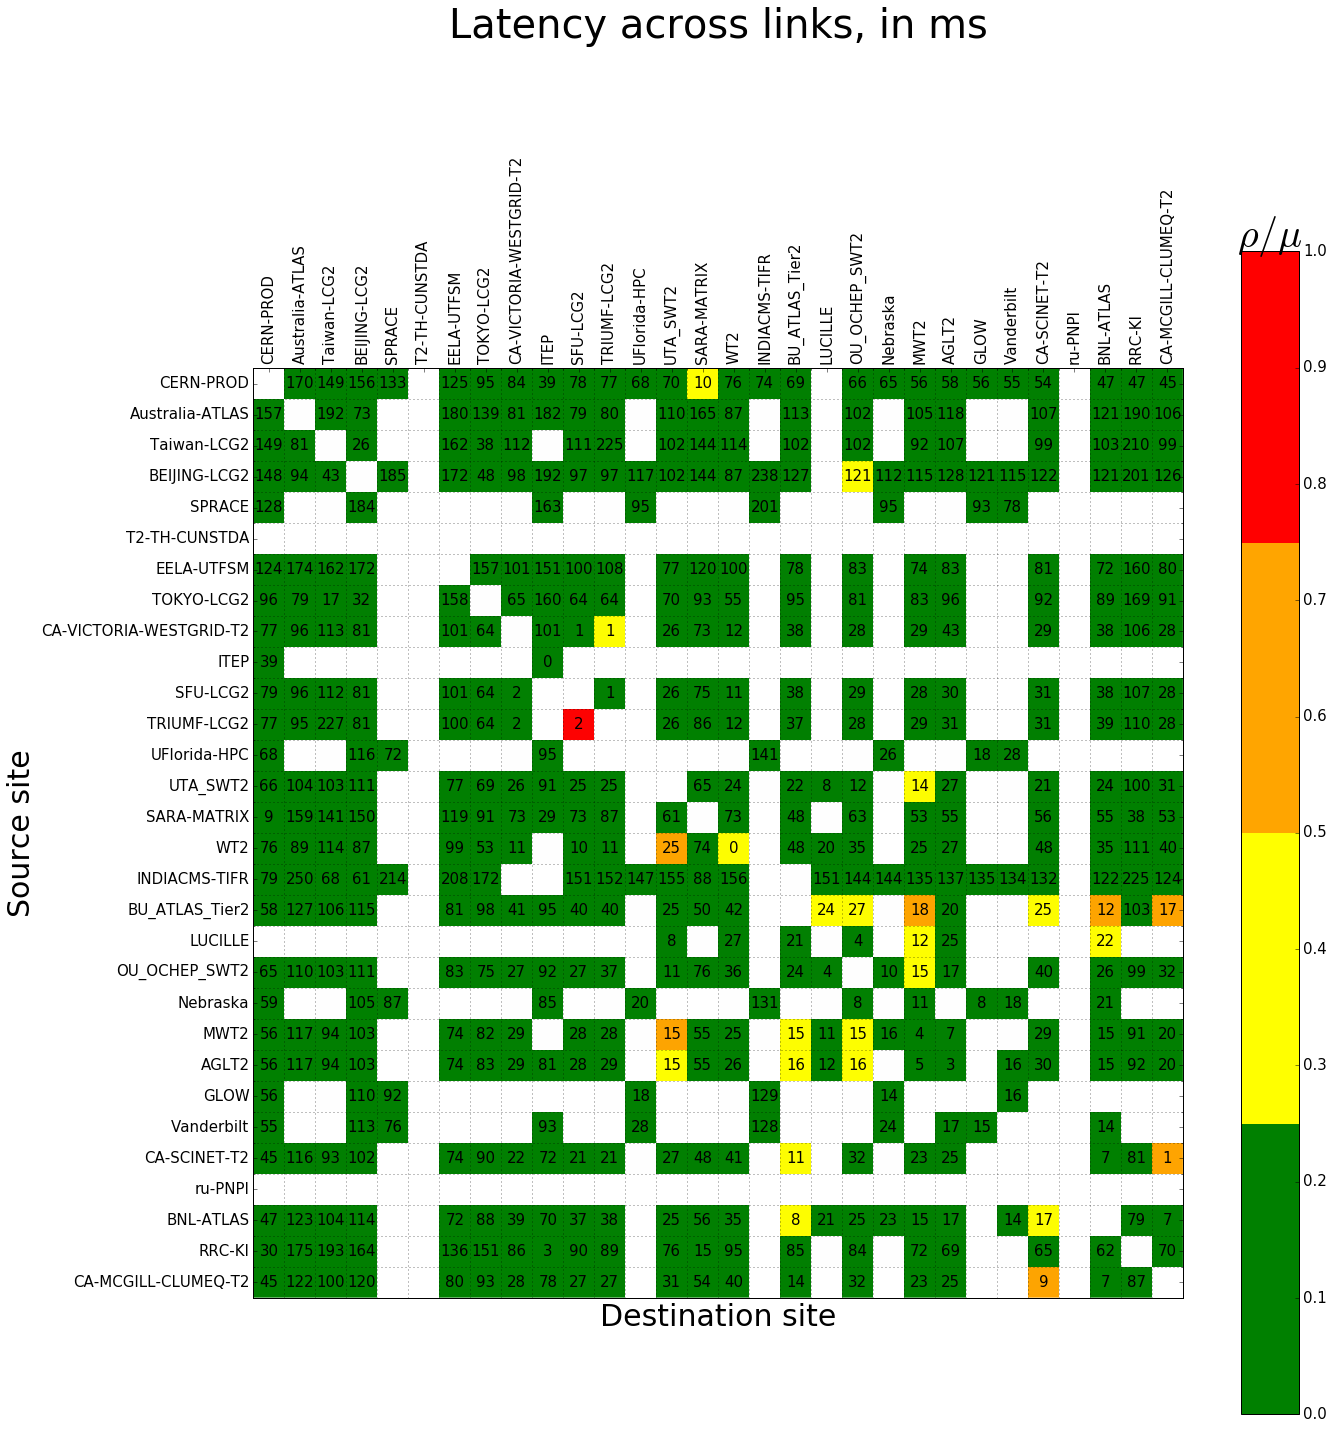

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import AutoMinorLocator
quality = s/m

#Display colors corresponding to latency stability
cMap = ListedColormap(['green', 'yellow','orange','red'])
plt.figure(figsize=(20,20))
#Force colormap to range between 0 and 1
plt.imshow(quality,vmin=0, vmax=1,cmap=cMap,interpolation='none')

#Adjust colorbar
cbar = plt.colorbar()
cbar.ax.set_title(r'$\rho / \mu$', size=40)
#Set numeric labels
for (j,i),label in np.ndenumerate(m):
    if np.logical_not(np.isnan(label)):
        plt.text(i,j,str(int(round(label))),color='k',size=15,ha='center',va='center')

        
ax = plt.gca() 


#Draw the boxes for the squares
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')

#Set major axis ticks and labels correctly
ax.yaxis.set_ticklabels(sites)
ax.xaxis.set_ticklabels(sites)
ax.xaxis.tick_top()

plt.yticks(range(dim),rotation=0)
plt.xticks(range(dim),rotation=90)

#Set titles
plt.ylabel('Source site',size=30)
plt.xlabel('Destination site',size=30)
plt.title('Latency across links, in ms\n',size=40,y=1.3)


plt.tight_layout()
plt.show()

In [9]:
tic = time.time()
totalClosenessData = []

index=0
for i in range(len(sites)):
    for j in range(len(sites)):
        closenessQuery = ast.literal_eval(query%(sites[i],sites[j],start,end,start,end,'closeness'))    
        response = es.search(index="atlas_ddm-metrics*", body=closenessQuery, request_timeout=600) 


        closenessData = []


        for r in response['aggregations']['2']['buckets']:
            closenessData.append(r['1']['value'])

    ## remove value/key pairs that are empty (Turn this into function to save space?)  ##      
        closenessData = np.array(closenessData,dtype=np.float)
        indices = np.logical_not(np.isnan(closenessData))

        totalClosenessData.append(closenessData)
        if index%50==0:
            print(index)
        index +=1
        
toc = time.time()

print('This aggregation over 30*30 links took %f seconds'%(toc-tic))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
This aggregation over 30*30 links took 304.936841 seconds


In [10]:
index = 0
dim = len(sites)
m_close = np.zeros((dim,dim))
s_close = np.zeros((dim,dim))
for i in range(dim):
    for j in range(dim):
        l = totalClosenessData[index]
        m_close[i,j] = np.nanmedian(l)
        s_close[i,j] = np.nanstd(l)
        index += 1

/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:689: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:689: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/

/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


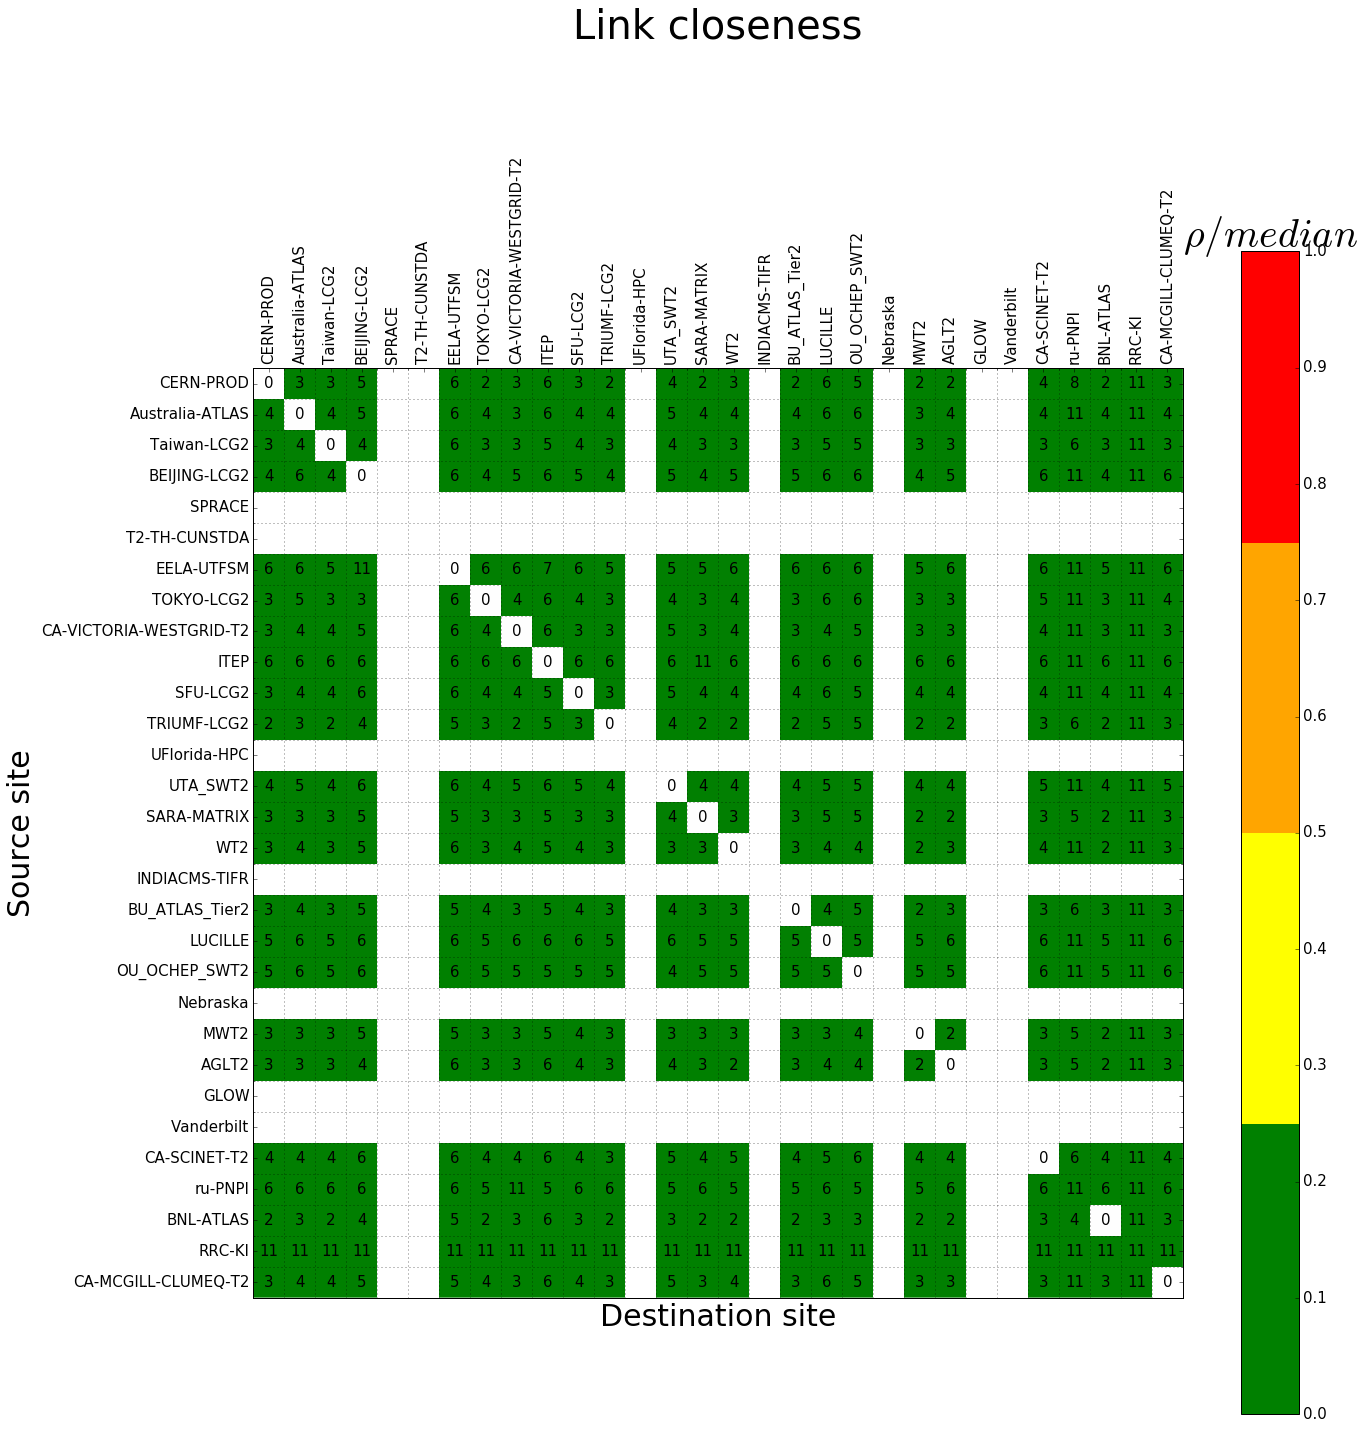

In [11]:
close_stability = s_close/m_close
#Display colors corresponding to latency stability
cMap = ListedColormap(['green', 'yellow','orange','red'])
plt.figure(figsize=(20,20))

#Force colormap to range between 0 and 1
plt.imshow(close_stability, vmin=0, vmax=1, cmap=cMap,interpolation='none')

#Adjust colorbar
cbar = plt.colorbar()
cbar.ax.set_title(r'$\rho / median$', size=40)
#Set numeric labels
for (j,i),label in np.ndenumerate(m_close):
    if np.logical_not(np.isnan(label)):
        plt.text(i,j,str(int(round(label))),color='k',size=15,ha='center',va='center')

        
ax = plt.gca() 


#Draw the boxes for the squares
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')

#Set major axis ticks and labels correctly
ax.yaxis.set_ticklabels(sites)
ax.xaxis.set_ticklabels(sites)
ax.xaxis.tick_top()

plt.yticks(range(dim),rotation=0)
plt.xticks(range(dim),rotation=90)

#Set titles
plt.ylabel('Source site',size=30)
plt.xlabel('Destination site',size=30)
plt.title('Link closeness\n',size=40,y=1.3)


plt.tight_layout()
plt.show()

In [12]:
tic = time.time()
totalQueuedData = []

milliDay = 24*60*60*1000
start = currentMilliTime - milliWeek

index=0
for i in range(len(sites)):
    for j in range(len(sites)):
        queuedQuery = ast.literal_eval(query%(sites[i],sites[j],start,end,start,end,'queued-total'))    
        response = es.search(index="atlas_ddm-metrics*", body=queuedQuery, request_timeout=600) 


        queuedData = []


        for r in response['aggregations']['2']['buckets']:
            queuedData.append(r['1']['value'])

    ## remove value/key pairs that are empty (Turn this into function to save space?)  ##      
        queuedData = np.array(queuedData,dtype=np.float)
        indices = np.logical_not(np.isnan(queuedData))

        totalQueuedData.append(queuedData)
        if index%50==0:
            print(index)
        index +=1
        
toc = time.time()

print('This aggregation over 30*30 links took %f seconds'%(toc-tic))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
This aggregation over 30*30 links took 289.539298 seconds


In [13]:
index = 0
dim = len(sites)
m_queued = np.zeros((dim,dim))
s_queued = np.zeros((dim,dim))
for i in range(dim):
    for j in range(dim):
        q = totalQueuedData[index]
        m_queued[i,j] = np.nanmean(q)
        s_queued[i,j] = np.nanstd(q)
        index += 1

/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/

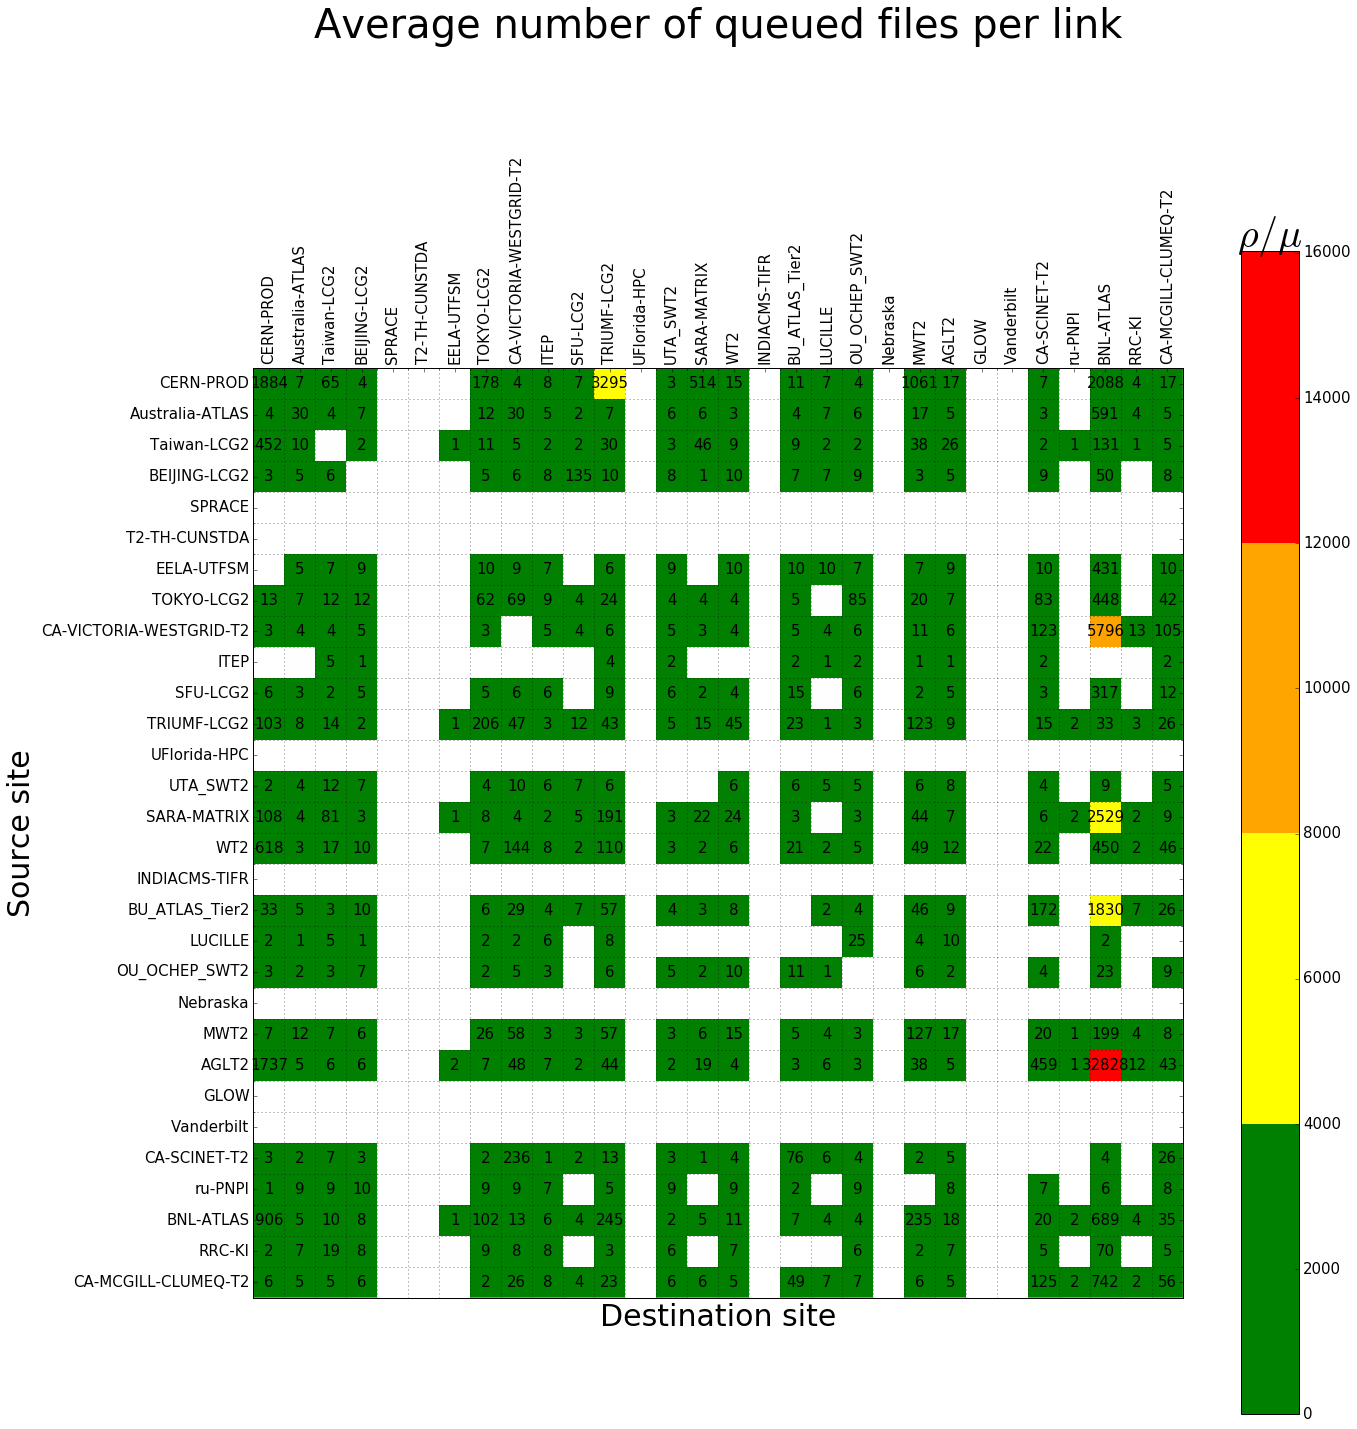

In [17]:
queued_stability = s_queued
#Display colors corresponding to latency stability
cMap = ListedColormap(['green', 'yellow','orange','red'])
plt.figure(figsize=(20,20))

#Force colormap to range between 0 and 1
plt.imshow(queued_stability, cmap=cMap,interpolation='none')

#Adjust colorbar
cbar = plt.colorbar()
cbar.ax.set_title(r'$\rho / \mu$', size=40)
#Set numeric labels
for (j,i),label in np.ndenumerate(m_queued):
    if np.logical_not(np.isnan(label)):
        plt.text(i,j,str(int(round(label))),color='k',size=15,ha='center',va='center')

        
ax = plt.gca() 


#Draw the boxes for the squares
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')

#Set major axis ticks and labels correctly
ax.yaxis.set_ticklabels(sites)
ax.xaxis.set_ticklabels(sites)
ax.xaxis.tick_top()

plt.yticks(range(dim),rotation=0)
plt.xticks(range(dim),rotation=90)

#Set titles
plt.ylabel('Source site',size=30)
plt.xlabel('Destination site',size=30)
plt.title('Average number of queued files per link\n',size=40,y=1.3)


plt.tight_layout()
plt.show()